# Прогнозирование временных рядов на карте

## Peer-graded Assignment: Оформление проекта

### Instructions

Определитесь, в каком виде вы хотите представить ваш проект. Мы предлагаем вам сделать интерактивное демо, содержащее:

- карты с визуализацией реального и прогнозируемого спроса на такси в выбираемый пользователем момент времени
- временной ряд фактического и прогнозируемого спроса на такси в выбираемой области.

Немного материалов о том, как в ноутбуках можно делать интерактивные графики:

- https://blog.dominodatalab.com/interactive-dashboards-in-jupyter/
- http://nbviewer.jupyter.org/github/quantopian/ipython/blob/master/examples/Interactive%20Widgets/Index.ipynb
- https://github.com/ioam/holoviews

Чтобы сдать задание, создайте демо и дайте ссылку на него.

### Решение

In [1]:
import json
import numpy as np
import pandas as pd
import ipywidgets as widgets
from matplotlib import pyplot as plt
from matplotlib import colors as colors

Нам понадобится библиотека bqplot.

In [2]:
# pip install bqplot
# jupyter nbextension enable --py bqplot

from bqplot import OrdinalScale, DateScale, LinearScale, Lines, Axis, Figure

Карту нарисуем с помощью библиотеки ipyleaflet.

In [3]:
# conda install -c conda-forge ipyleaflet
# jupyter nbextension enable --py --sys-prefix ipyleaflet
# jupyter nbextension enable --py --sys-prefix widgetsnbextension

from ipyleaflet import Map, GeoJSON

Удобный класс для двух слайдеров -- выбор начала и конца периода.

http://stackoverflow.com/a/39268222

In [4]:
class DateRangePicker(object):
    def __init__(self, start, end, freq='H', fmt='%Y-%m-%d %H', cb=None):
        """
        Parameters
        ----------
        start : string or datetime-like
            Left bound of the period
        end : string or datetime-like
            Right bound of the period
        freq : string or pandas.DateOffset, default='H'
            Frequency strings can have multiples, e.g. '5H' 
        fmt : string, default = '%Y-%m-%d %H'
            Format to use to display the selected period

        """
        date_range = pd.date_range(start=start, end=end, freq=freq)
        options = [(item.strftime(fmt), np.datetime64(item)) for item in date_range]
        self.slider_start = widgets.SelectionSlider(
            description='Start:',
            options=options,
            continuous_update=False,
            layout=widgets.Layout(width='100%')
        )
        self.slider_end = widgets.SelectionSlider(
            description='End:',
            options=options,
            continuous_update=False,
            value=options[-1][1],
            layout=widgets.Layout(width='100%')
        )
        self.cb = cb
        self.slider_start.observe(self.handle_change, 'value')
        self.slider_end.observe(self.handle_change, 'value')
        self.widget = widgets.Box(children=[self.slider_start, self.slider_end])
    
    def handle_change(self, d):
        #print("{name} changed from {old} to {new}".format(**d))
        if self.cb:
            self.cb(self.slider_start.value, self.slider_end.value)

Определение координат региона по его идентификатору.

In [5]:
# New-York 
ny_west = -74.25559 
ny_east = -73.70001
ny_south = 40.49612
ny_north = 40.91553

In [6]:
def get_coords(region):
    i = int((region - 1) / 50)
    j = (region - 1) % 50
    dx = (ny_east - ny_west) / 50
    dy = (ny_north - ny_south) / 50
    west = i * dx + ny_west
    south = j * dy + ny_south
    return west, west + dx, south, south + dy

Загрузка данных.

In [7]:
tripdata = json.load(open("tripdata.json"))

In [8]:
regions = sorted(tripdata['actual'].keys())  # list of string region id
steps = sorted(tripdata['forecast'].keys()) # '1' .. '6'

In [9]:
# Convert to numpy arrays
hours = np.array(map(np.datetime64, tripdata['hours']))
for region in regions:
    tripdata['actual'][region] = np.array(tripdata['actual'][region])
    for step in steps:
        tripdata['forecast'][step][region] = np.array(tripdata['forecast'][step][region])

Основной график -- содержит фактические и прогнозируемые данные о количестве поездок.

In [10]:
x_sc = DateScale()
y_sc = LinearScale()

selected = {'step': steps[0], 'region': regions[0], 
            'start': hours[0], 'end': hours[-1]}

aline = Lines(scales={'x': x_sc, 'y': y_sc},
             stroke_width=1, colors=['blue'], display_legend=True, 
             labels=[u'Actual']
            )
fline = Lines(scales={'x': x_sc, 'y': y_sc},
             stroke_width=1, colors=['red'], display_legend=True, 
             labels=[u'Forecast']
            )

ax_x = Axis(scale=x_sc, grid_lines='solid', label=u'Hour')
ax_y = Axis(scale=y_sc, orientation='vertical', tick_format='0.0f',
            grid_lines='solid', label=u'Trip count')

f = Figure(marks=[aline, fline], axes=[ax_x, ax_y], min_width=1000, min_height=400, 
           title=u'New-York yellow taxi trips',legend_location='top-right',)

def update_lines():
    v = (hours >= selected['start']) & (hours <= selected['end'])
    x = hours[v]
    aline.x = x
    fline.x = x
    fline.y = tripdata['forecast'][selected['step']][selected['region']][v]
    aline.y = tripdata['actual'][selected['region']][v]
    
update_lines()

Центр карты поставим в середину наших регионов.

In [11]:
all_coords = map(get_coords, map(int, regions))
min_lon = min(map(lambda x: x[0], all_coords))
max_lon = max(map(lambda x: x[1], all_coords))
min_lat = min(map(lambda x: x[2], all_coords))
max_lat = max(map(lambda x: x[3], all_coords))

На карту нанесём наши регионы, окрашенные по количеству среднего количества поездок.

In [12]:
def make_geo_json(regions):
    reg_avg = {region: np.mean(tripdata['actual'][region]) for region in regions}
    reg_max = max(reg_avg.values())
    colormap = plt.get_cmap('Blues')
    data = {'type': 'FeatureCollection', 'features': []}
    for region in regions:
        i = int(float(colormap.N) * np.log(reg_avg[region]) / np.log(reg_max))
        rgb = colormap(i)[:3] # will return rgba, we take only first 3 so we get rgb
        color = colors.rgb2hex(rgb)
        w, e, s, n = get_coords(int(region))
        coordinates = [[w, s], [w, n], [e, n], [e, s]]
        data['features'].append({
            'id': region,
            'type': 'Feature',
            'geometry': {'coordinates': [[coordinates]], 'type': 'MultiPolygon'},
            'properties': {'style': {'color': color, 'fillColor': color, 
                                     'fillOpacity': 0.5, 'weight': 1}},
        })
    return GeoJSON(data=data, hover_style={'fillColor': 'red'})

Создадим объект карты, добавим слой регионов и ховер-хендлер.

In [13]:
center = [(min_lat + max_lat) / 2, (min_lon + max_lon) / 2]
zoom = 11

m = Map(center=center, zoom=zoom, scroll_wheel_zoom=True, 
        layout=widgets.Layout(width='50%', height='450px'))

def region_handler(event=None, id=None, properties=None):
    selected['region'] = id
    update_lines()

g = make_geo_json(regions)
g.on_hover(region_handler)
m.add_layer(g)

Объект для выбора начала и конца рассматриваемого периода.

In [14]:
def date_range_handler(start, end):
    selected['start'] = start
    selected['end'] = end
    update_lines()

drp = DateRangePicker(start=hours[0], end=hours[-1], cb=date_range_handler)
drp.widget.layout = widgets.Layout(width='100%', margin='50px 0 0 0')

Объект для выбора шага прогноза (мы сделали 6 моделей для прогнозирования на 1, ..., 6 часов).

In [15]:
def step_pair(step):
    label = 'hour' if step == '1' else 'hours'
    return (step + ' ' + label, step)

options = map(step_pair, steps)
ss = widgets.SelectionSlider(description=u'Step:', options=options, continuous_update=False, 
                             value=options[0][1], layout=widgets.Layout(width='100%', margin='150px 0 0 0'))
def step_handler(d):
    selected['step'] = d['new']
    update_lines()
    
ss.observe(step_handler, 'value')

Блок слайдеров.

In [16]:
sliders = widgets.VBox([drp.widget, ss], layout=widgets.Layout(width='45%'))

Блок управления (карта + слайдеры).

In [17]:
controls = widgets.HBox([m, sliders])

И вот что получилось. Можно навести мышь на регион или крутить линейки периода и шага.

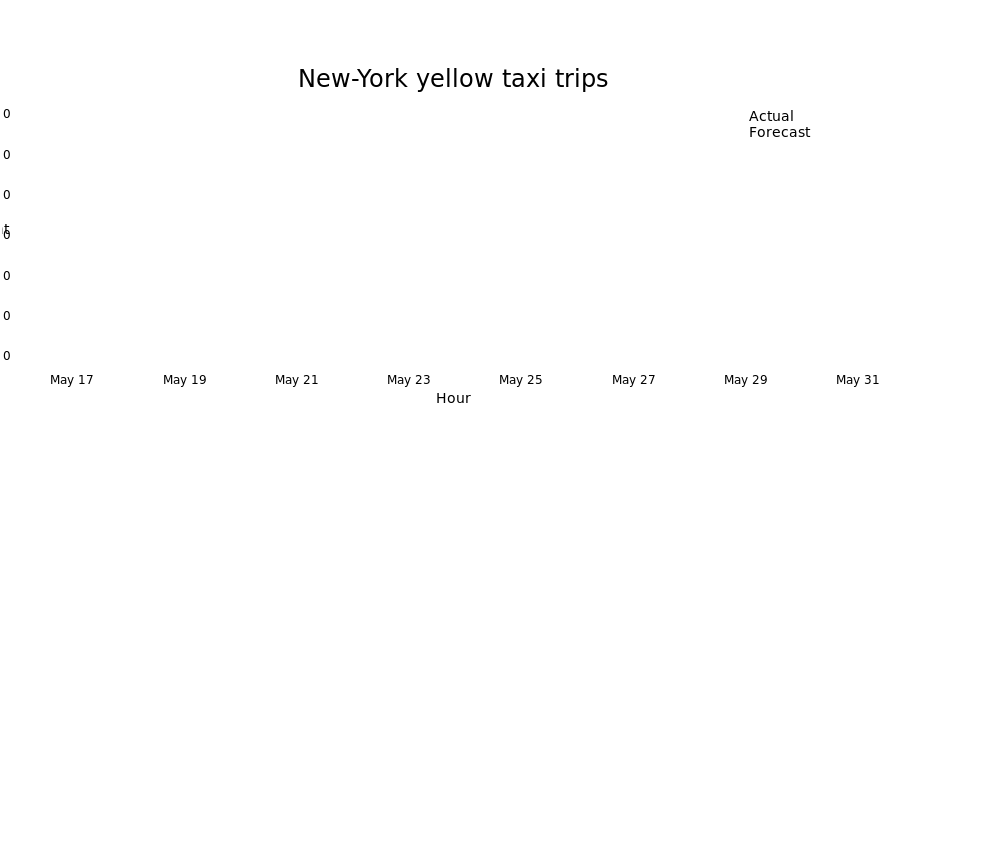

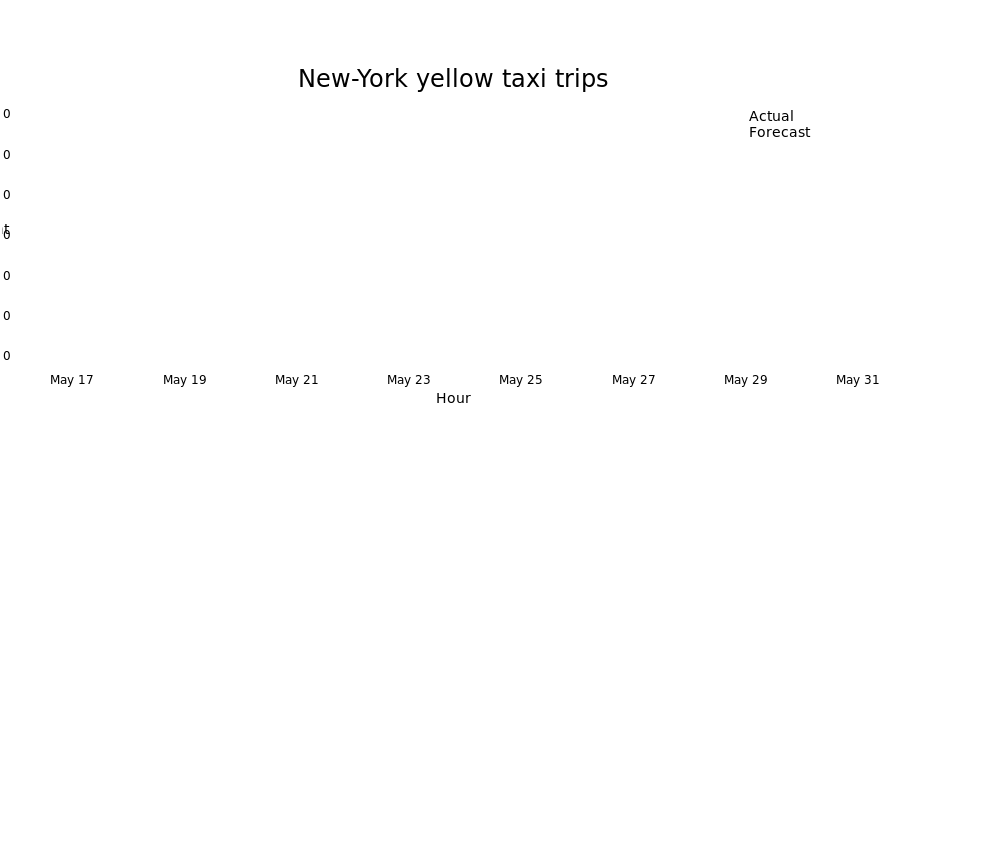

In [18]:
widgets.VBox([f, controls])

### Если виджет не сохранился

- Можно установить bqplot и ipyleaflet (это совсем не трудно, инструкции даны выше) и исполнить тетрадку.
- Можно посмотреть на скриншот того, что здесь было:

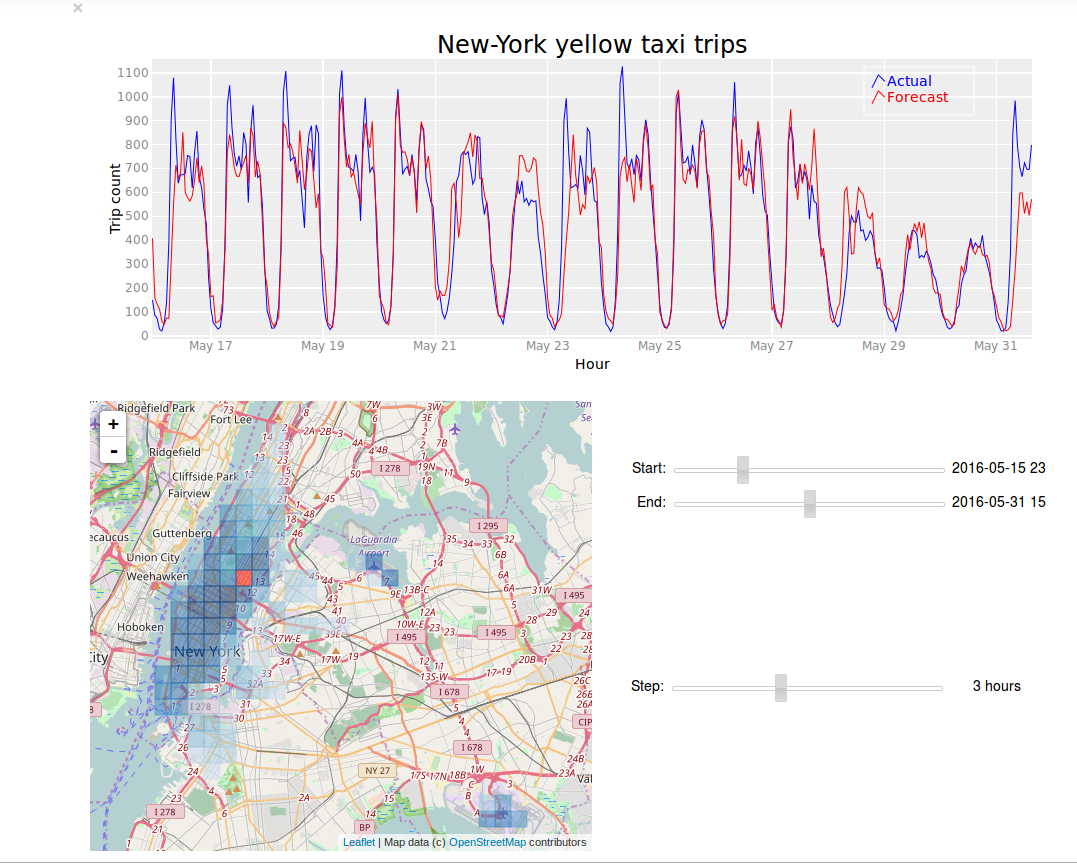

In [24]:
from IPython.display import Image
Image("w7scr.png", width=1000, embed=True)